# Morphen utilities for image analysis

- **Author:** Geferson Lucatelli (gefersonlucatelli@gmail.com)
- **Affiliation:** University of Manchester, JBCA
- **Created on:** April 01, 2025


In [33]:
import sys
import argparse
import os
morphen_path = '../morphen/'
sys.path.append(morphen_path)
sys.path.append(morphen_path+'analysis_scripts/')
import morphen as mp
import mlibs as mlibs
import numpy as np
import warnings
import casaviewer


warnings.filterwarnings("ignore", category=RuntimeWarning)

def reload_libs():
    """
    This allows you to reload the library file without restarting the kernel.
    
    Usage:
    In [1]: reload_libs()
    """
    import mlibs as mlibs
    from importlib import reload
    reload(mlibs)
    import morphen as mp
    reload(mp)



def convert_dtype(column):
    try:
        return column.astype(float)
    except ValueError:
        try:
            return column.astype(int)
        except ValueError:
            return column

Currently, an easy way to read multiple images into here is though `glob`. Function `mlibs.prepare_data` deals with that, just specify the `root_path` of the images and the `prefix_images` for each path. 

Note that multiple paths could be specified. 

The function will return `WSClean` MFS and sub-band images, with associated residual images. 
`Morphen` requires the residual images to properly work. 


In [34]:
source_name = 'NGC7674'
root_path = [
             "/tmp/disk/LIRGI_Sample_done/for_spix/NGC7674/eM_C_Ka/C/",
            ]
prefix_images = [
                 "im_nc6_cb_bs_0.06asec_*0.008asec*r0.0*-????-image-pb.fits",
                ]

# root_path = [
#              "/tmp/disk/LIRGI_Sample_done/eMERLIN/LegacyArchive/C_band/NGC7674/imaging_final/",
#             ]
# prefix_images = [
#                  "im_nc8_cb_bs_0.04asec_NGC7674_eM_C_sfc_ps_*0.008asec*r0.5*-????-image-pb.fits",
#                 ]



In [35]:
MFS_images,MFS_residuals,\
    imagelist,residuallist,\
    freqlist_MFS,freqlist = mlibs.prepare_data(root_path,prefix_images)


0 >> im_nc6_cb_bs_0.06asec_NGC7674_eM_C_sfc_ps_highres_C_Ka_1024x1024_0.008asec_multiscale__r0.0-0000-image-pb.fits
1 >> im_nc6_cb_bs_0.06asec_NGC7674_eM_C_sfc_ps_highres_C_Ka_1024x1024_0.008asec_multiscale__r0.0-0001-image-pb.fits
2 >> im_nc6_cb_bs_0.06asec_NGC7674_eM_C_sfc_ps_highres_C_Ka_1024x1024_0.008asec_multiscale__r0.0-0002-image-pb.fits
3 >> im_nc6_cb_bs_0.06asec_NGC7674_eM_C_sfc_ps_highres_C_Ka_1024x1024_0.008asec_multiscale__r0.0-0003-image-pb.fits
4 >> im_nc6_cb_bs_0.06asec_NGC7674_eM_C_sfc_ps_highres_C_Ka_1024x1024_0.008asec_multiscale__r0.0-0004-image-pb.fits
5 >> im_nc6_cb_bs_0.06asec_NGC7674_eM_C_sfc_ps_highres_C_Ka_1024x1024_0.008asec_multiscale__r0.0-0005-image-pb.fits


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 60.53it/s]


++>> Image File: im_nc6_cb_bs_0.06asec_NGC7674_eM_C_sfc_ps_highres_C_Ka_1024x1024_0.008asec_multiscale__r0.0-MFS-image-pb.fits
++>> Residual File: im_nc6_cb_bs_0.06asec_NGC7674_eM_C_sfc_ps_highres_C_Ka_1024x1024_0.008asec_multiscale__r0.0-MFS-residual-pb.fits
-->> No PSF File was provided.
  >> Center -->  [494 517   0   0]


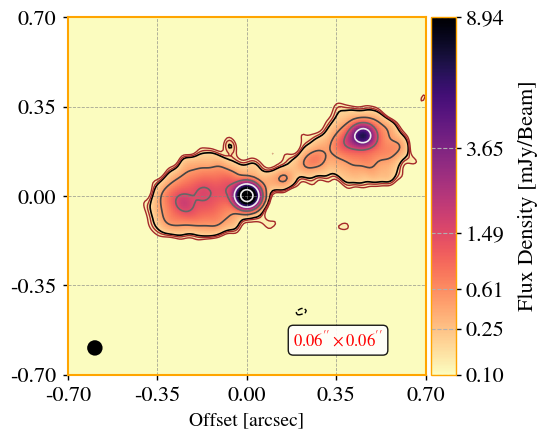

In [36]:
# lets select another image from our list of images. 
idx = 0#select one index from the list. 
cutout_size = 175
input_data=mp.read_data(filename=MFS_images[idx],
                        residualname=MFS_residuals[idx])
ax=mlibs.eimshow(input_data.filename,crop=True,box_size=int(cutout_size/2),add_beam=True,plot_colorbar=True)

maxpos =  [494 517   0   0]
maxposf =  23:27:56.7097, +08.46.44.1400, 5.25002e+09Hz, I
ra_f, dec_f =  351.98629041666663 8.77892777777778
        > Offset of image position is: (0, 0).
        > Offset of image position is: (0, 0).
        > Offset of image position is: (0, 0).
        > Offset of image position is: (0, 0).
        > Offset of image position is: (0, 0).
        > Offset of image position is: (0, 0).
        > Offset of image position is: (0, 0).


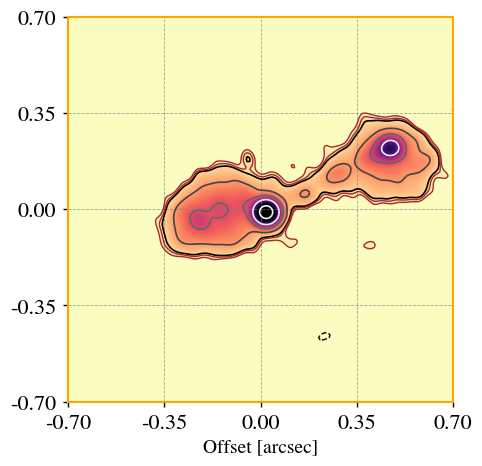

In [37]:
# reload_libs()
special_name = 'total_highres'
ra,dec,new_filename = mlibs.cutout_2D_radec(imagename=input_data.filename,
                                            residualname=input_data.residualname,
                                            cutout_size = cutout_size,
                                            special_name=special_name)
mlibs.eimshow(new_filename)

imagelist_c = []
residuallist_c = []
for i in (range(len(imagelist))):
    _,_,image_c = mlibs.cutout_2D_radec(imagename=imagelist[i],
                                            residualname=residuallist[i],
                                            ra_f=ra,dec_f=dec,
                                            cutout_size = cutout_size,
                                            # shift_correction_mode = 'structural',
                                            correct_shift=True,ref_cutout_image=new_filename,
                                            special_name=special_name)
    imagelist_c.append(image_c)
    residuallist_c.append(image_c.replace('-image.cutout.','-residual.cutout.').replace('-image-pb.cutout.','-residual-pb.cutout.'))
    
MFS_images_c = []
MFS_residuals_c = []
for i in (range(len(MFS_images))):
    _,_,MFS_image_c = mlibs.cutout_2D_radec(imagename=MFS_images[i],
                                            residualname=MFS_residuals[i],
                                            ra_f=ra,dec_f=dec,
                                            # shift_correction_mode = 'structural',
                                            cutout_size = cutout_size,
                                            correct_shift=True,ref_cutout_image=new_filename,
                                            special_name=special_name)
    MFS_images_c.append(MFS_image_c)
    MFS_residuals_c.append(MFS_image_c.replace('-MFS-image.cutout.','-MFS-residual.cutout.').replace('-MFS-image-pb.cutout.','-MFS-residual-pb.cutout.'))


In [38]:
MFS_images_c

['/tmp/disk/LIRGI_Sample_done/for_spix/NGC7674/eM_C_Ka/C/im_nc6_cb_bs_0.06asec_NGC7674_eM_C_sfc_ps_highres_C_Ka_1024x1024_0.008asec_multiscale__r0.0-MFS-image-pb.cutout.total_highres.fits']

In [39]:
MFS_residuals_c

['/tmp/disk/LIRGI_Sample_done/for_spix/NGC7674/eM_C_Ka/C/im_nc6_cb_bs_0.06asec_NGC7674_eM_C_sfc_ps_highres_C_Ka_1024x1024_0.008asec_multiscale__r0.0-MFS-residual-pb.cutout.total_highres.fits']

## Basic Image and Sub-region analysis

Now we proceed to characterise global and sub-region image morphology. We use basic source detection algorithms to detect featured regions of the radio emission. 


Another relevant step is to generate a global mask that will be used to compute image morphology along multiple images. That is done with the function `mlibs.mask_dilation`.

In [49]:
idx = 0 #select one index from the list. 
input_data=mp.read_data(filename=MFS_images_c[idx],
                        residualname=MFS_residuals_c[idx])

++>> Image File: im_nc6_cb_bs_0.06asec_NGC7674_eM_C_sfc_ps_highres_C_Ka_1024x1024_0.008asec_multiscale__r0.0-MFS-image-pb.cutout.total_highres.fits
++>> Residual File: im_nc6_cb_bs_0.06asec_NGC7674_eM_C_sfc_ps_highres_C_Ka_1024x1024_0.008asec_multiscale__r0.0-MFS-residual-pb.cutout.total_highres.fits
-->> No PSF File was provided.


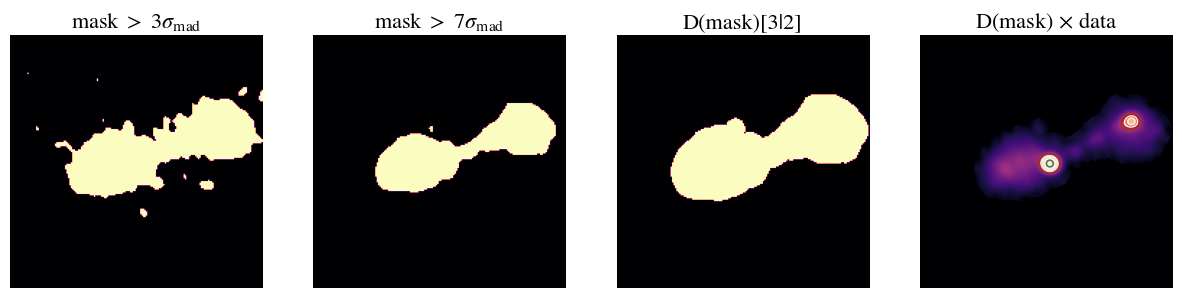

<Figure size 500x500 with 0 Axes>

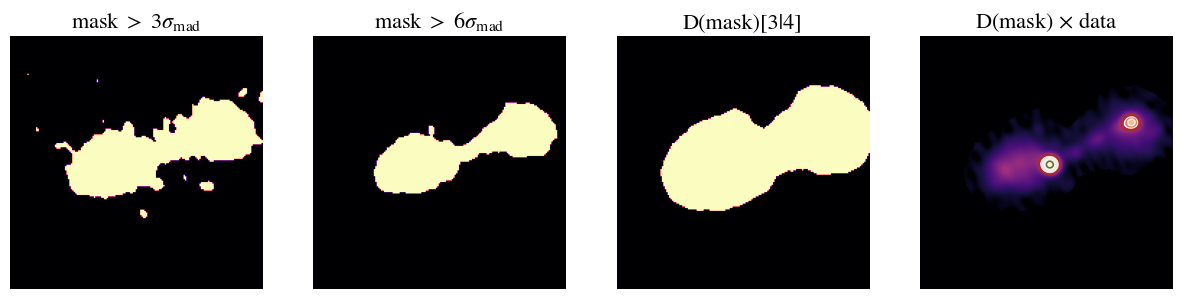

<Figure size 500x500 with 0 Axes>

In [50]:
_, mask = mlibs.mask_dilation(MFS_images_c[idx], 
                              sigma=7, 
                              dilation_size=None,
                              iterations=2, show_figure=True,PLOT=True,
                              rms=mlibs.mad_std(mlibs.load_fits_data(MFS_residuals_c[idx])))

_, mask_max = mlibs.mask_dilation(MFS_images_c[idx], 
                              sigma=6, 
                              dilation_size=None,
                              iterations=4, show_figure=True,PLOT=True,
                              rms=mlibs.mad_std(mlibs.load_fits_data(MFS_residuals_c[idx])))


                                                          ..___|**_
                                                  .|||||||||*+@+*__*++.
                                              _||||.           .*+;].,#_
                                         _|||*_                _    .@@@#@.
                                   _|||||_               .@##@#| _||_
       Morphen                |****_                   .@.,/\..@_.
                             #///#+++*|    .       .@@@;#.,.\@.
                              .||__|**|||||*||*+@#];_.  ;,;_
 Geferson Lucatelli                            +\*_.__|**#
                                              |..      .]]
                                               ;@       @.*.
                                                #|       _;]];|.
                                                 ]_          _+;]@.
                                                 _/_             |]\|    .  _
                                              ...._@* __ .

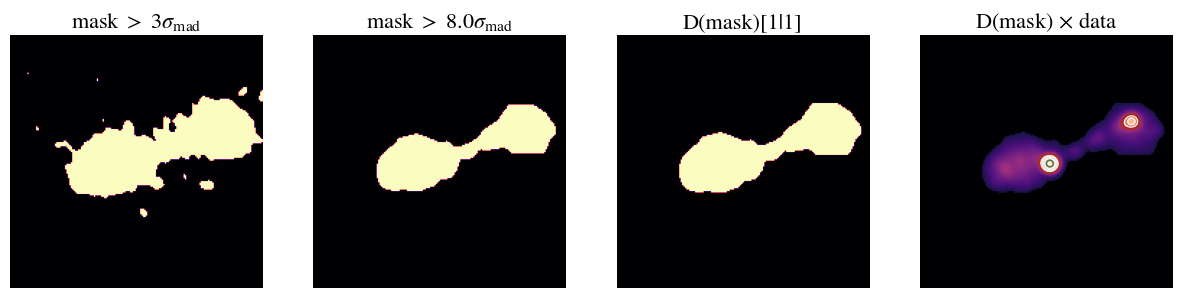

<Figure size 500x500 with 0 Axes>

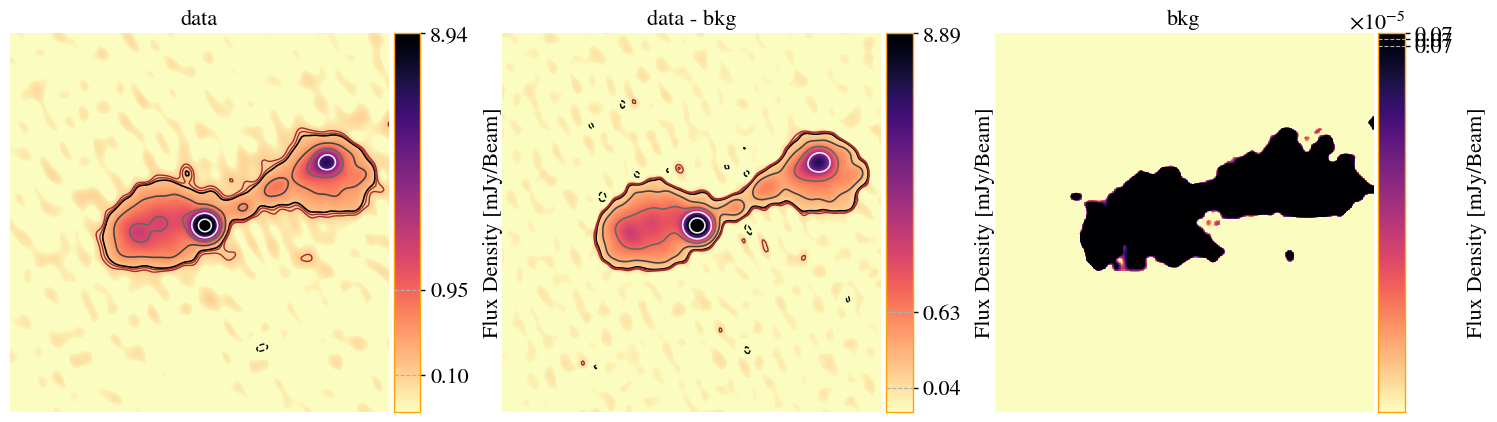

Deblending:   0%|          | 0/2 [00:00<?, ?it/s]

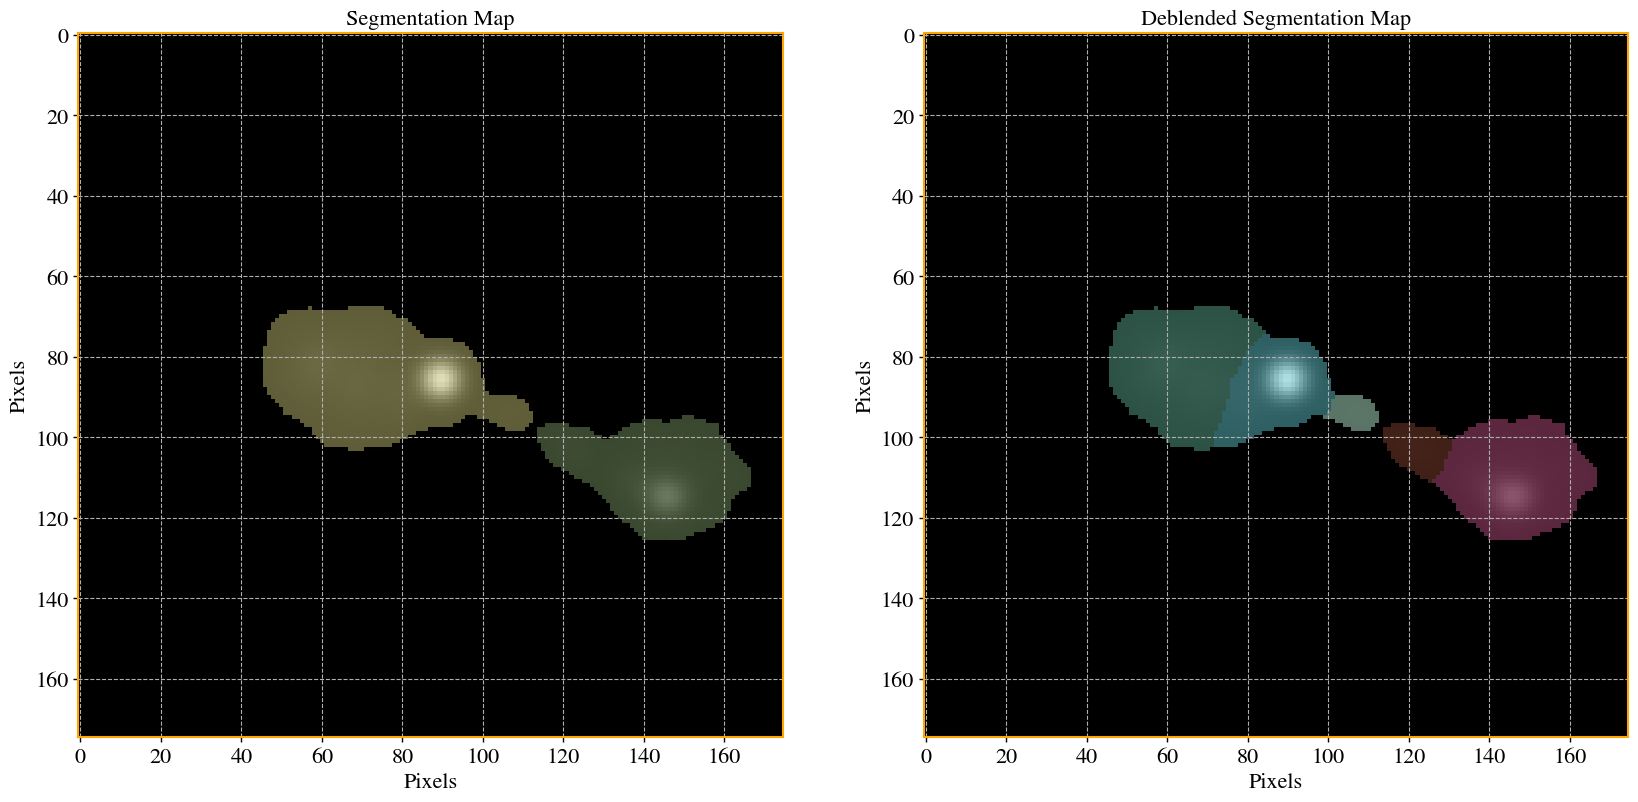

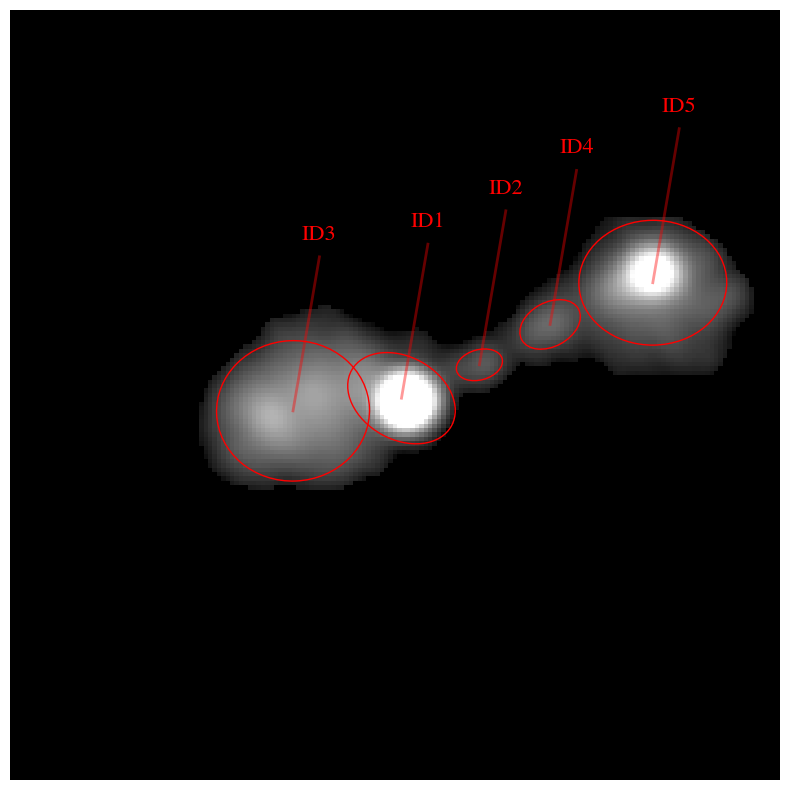

In [51]:
reload_libs()
#this is a set of parameters that may work OKAY
bwf, bhf = 2.0, 2.0 # standard value that works for a wide range of images. But, additional check is required!!!!
fwf, fhf = 2.0, 2.0 # standard value that works for a wide range of images. But, additional check is required!!!!
clean_param = 0.5
deblend_cont = 1e-5
deblend_nthresh = 50
sigma_mask = 8.0
sigma = 8.0
minarea_factor = 0.5
ell_size_factor = 2
SE = mp.source_extraction(input_data, 
                          ell_size_factor = ell_size_factor, sigma = sigma,
                          algorithm='PF',
                          bwf = bwf,bhf = bhf,fwf = fwf, fhf = fhf,
                          clean_param = clean_param, 
                          deblend_cont = deblend_cont, 
                          deblend_nthresh=deblend_nthresh,minarea_factor=minarea_factor,
                          apply_mask=True,sigma_mask=sigma_mask,
                          show_petro_plots=True,show_bkg_map=True,
                          sort_by = 'distance',
                          dilation_size=1,
                          dry_run=True)
# plt.imshow(input_data.image_data_2D)

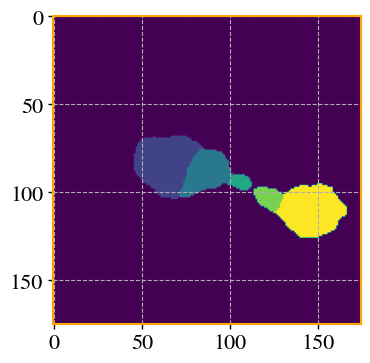

In [53]:
mlibs.plt.imshow(SE.seg_maps)

The function `mlibs.structural_morphology` will perform some image characterisation tasks for each image (in this case, we are firstly running it on `MFS_images_c`. The variable `df_results_morpho_MFS` is a pandas dataframe storing all derived quantities from each image on the list. 

Key quantities are given below. 



  0%|                                                                                                                                                                                                                             | 0/1 [00:00<?, ?it/s]

Using RMS from residual
     >> INFO: Using provided mask.
     >> CALC: Computing image properties.
-----------------------------------------------------------------
Flux Density and error (based on rms of residual x area): 
Flux Density = 57.66 +/- 1.61 mJy
Fractional error = 0.03
Flux Density and error (quadrature |fract_err + res_err + rms|): 
Flux Density = 57.66 +/- 2.98 mJy
Fractional error = 0.05
-----------------------------------------------------------------
 ==>  Peak of Flux      = 17.87 +/- 0.03 [mJy/beam]
 ==>  Snu (within mask) = 57.66 +/- 1.61 [mJy]
 ==>  Snu (image)       = 57.57 +/- 1.61 [mJy]
 ==>  R50               = 0.0917 +/- 0.0131 [arcsec]
 ==>  R95               = 0.2544 +/- 0.0273 [arcsec]
 ==>  A50               = (9.5217 +/- 2.7249) x 1e3 [kpc^-2]
 ==>  A95               = (73.3388 +/- 15.4936) x 1e3 [kpc^-2]
 ==>  R50               = 55.0533 +/- 7.8766 [pc]
 ==>  R95               = 152.7890 +/- 16.4072 [pc]


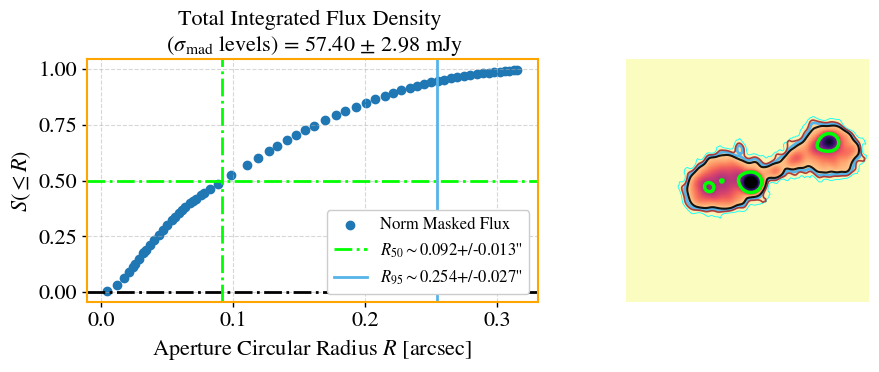

     >> INFO: Using provided mask.
     >> CALC: Computing image properties.
-----------------------------------------------------------------
Flux Density and error (based on rms of residual x area): 
Flux Density = 23.57 +/- 0.21 mJy
Fractional error = 0.01
Flux Density and error (quadrature |fract_err + res_err + rms|): 
Flux Density = 23.57 +/- 1.18 mJy
Fractional error = 0.05
-----------------------------------------------------------------
 ==>  Peak of Flux      = 17.87 +/- 0.03 [mJy/beam]
 ==>  Snu (within mask) = 23.57 +/- 0.21 [mJy]
 ==>  Snu (image)       = 23.57 +/- 0.21 [mJy]
 ==>  R50               = 0.0359 +/- 0.0029 [arcsec]
 ==>  R95               = 0.0922 +/- 0.0113 [arcsec]
 ==>  A50               = (1.4610 +/- 0.2390) x 1e3 [kpc^-2]
 ==>  A95               = (9.6327 +/- 2.3249) x 1e3 [kpc^-2]
 ==>  R50               = 21.5648 +/- 1.7615 [pc]
 ==>  R95               = 55.3731 +/- 6.7879 [pc]


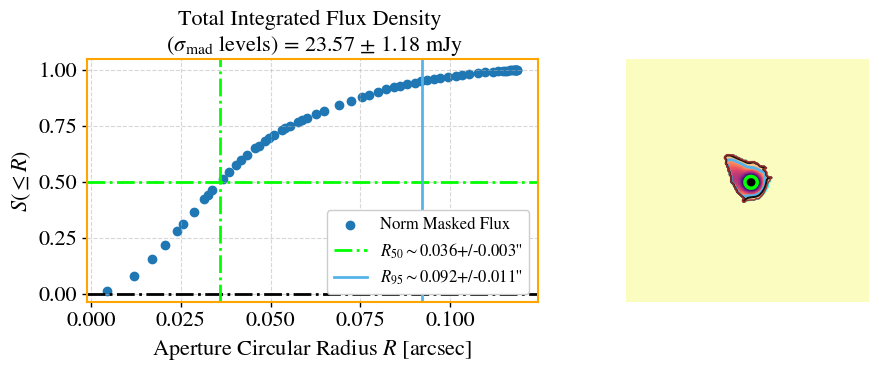

     >> INFO: Using provided mask.
     >> CALC: Computing image properties.
-----------------------------------------------------------------
Flux Density and error (based on rms of residual x area): 
Flux Density = 0.83 +/- 0.05 mJy
Fractional error = 0.06
Flux Density and error (quadrature |fract_err + res_err + rms|): 
Flux Density = 0.83 +/- 0.06 mJy
Fractional error = 0.08
-----------------------------------------------------------------
 ==>  Peak of Flux      = 0.55 +/- 0.03 [mJy/beam]
 ==>  Snu (within mask) = 0.83 +/- 0.05 [mJy]
 ==>  Snu (image)       = 0.83 +/- 0.05 [mJy]
 ==>  R50               = 0.0359 +/- 0.0023 [arcsec]
 ==>  R95               = 0.0584 +/- 0.0024 [arcsec]
 ==>  A50               = (1.4578 +/- 0.1884) x 1e3 [kpc^-2]
 ==>  A95               = (3.8620 +/- 0.3141) x 1e3 [kpc^-2]
 ==>  R50               = 21.5413 +/- 1.3921 [pc]
 ==>  R95               = 35.0616 +/- 1.4430 [pc]


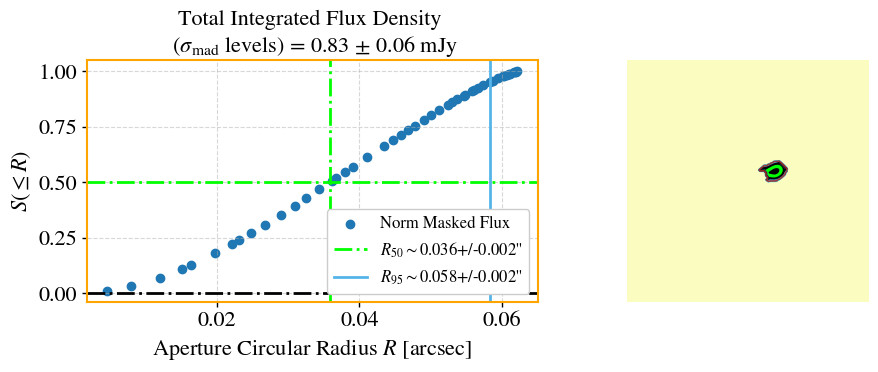

     >> INFO: Using provided mask.
     >> CALC: Computing image properties.
-----------------------------------------------------------------
Flux Density and error (based on rms of residual x area): 
Flux Density = 13.37 +/- 0.34 mJy
Fractional error = 0.03
Flux Density and error (quadrature |fract_err + res_err + rms|): 
Flux Density = 13.37 +/- 0.70 mJy
Fractional error = 0.05
-----------------------------------------------------------------
 ==>  Peak of Flux      = 1.86 +/- 0.03 [mJy/beam]
 ==>  Snu (within mask) = 13.37 +/- 0.34 [mJy]
 ==>  Snu (image)       = 13.37 +/- 0.34 [mJy]
 ==>  R50               = 0.0801 +/- 0.0052 [arcsec]
 ==>  R95               = 0.1412 +/- 0.0086 [arcsec]
 ==>  A50               = (7.2682 +/- 0.9499) x 1e3 [kpc^-2]
 ==>  A95               = (22.6062 +/- 2.7174) x 1e3 [kpc^-2]
 ==>  R50               = 48.0994 +/- 3.1418 [pc]
 ==>  R95               = 84.8279 +/- 5.1687 [pc]


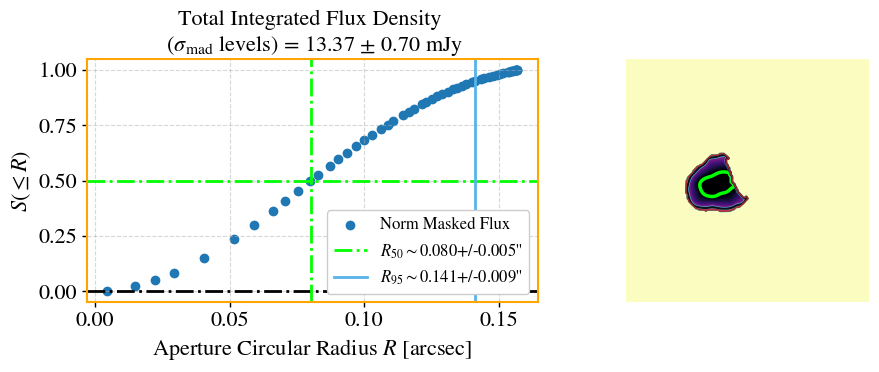

     >> INFO: Using provided mask.
     >> CALC: Computing image properties.
-----------------------------------------------------------------
Flux Density and error (based on rms of residual x area): 
Flux Density = 1.65 +/- 0.08 mJy
Fractional error = 0.05
Flux Density and error (quadrature |fract_err + res_err + rms|): 
Flux Density = 1.65 +/- 0.11 mJy
Fractional error = 0.07
-----------------------------------------------------------------
 ==>  Peak of Flux      = 0.75 +/- 0.03 [mJy/beam]
 ==>  Snu (within mask) = 1.65 +/- 0.08 [mJy]
 ==>  Snu (image)       = 1.65 +/- 0.08 [mJy]
 ==>  R50               = 0.0434 +/- 0.0028 [arcsec]
 ==>  R95               = 0.0717 +/- 0.0029 [arcsec]
 ==>  A50               = (2.1369 +/- 0.2776) x 1e3 [kpc^-2]
 ==>  A95               = (5.8305 +/- 0.4621) x 1e3 [kpc^-2]
 ==>  R50               = 26.0805 +/- 1.6938 [pc]
 ==>  R95               = 43.0803 +/- 1.7275 [pc]


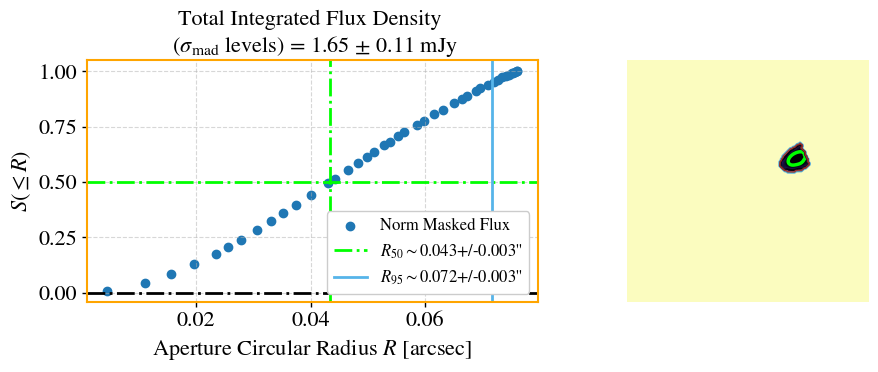

     >> INFO: Using provided mask.
     >> CALC: Computing image properties.
-----------------------------------------------------------------
Flux Density and error (based on rms of residual x area): 
Flux Density = 16.01 +/- 0.36 mJy
Fractional error = 0.02
Flux Density and error (quadrature |fract_err + res_err + rms|): 
Flux Density = 16.01 +/- 0.83 mJy
Fractional error = 0.05
-----------------------------------------------------------------
 ==>  Peak of Flux      = 6.76 +/- 0.03 [mJy/beam]
 ==>  Snu (within mask) = 16.01 +/- 0.36 [mJy]
 ==>  Snu (image)       = 16.01 +/- 0.36 [mJy]
 ==>  R50               = 0.0557 +/- 0.0058 [arcsec]
 ==>  R95               = 0.1365 +/- 0.0102 [arcsec]
 ==>  A50               = (3.5141 +/- 0.7420) x 1e3 [kpc^-2]
 ==>  A95               = (21.1186 +/- 3.0874) x 1e3 [kpc^-2]
 ==>  R50               = 33.4451 +/- 3.5106 [pc]
 ==>  R95               = 81.9894 +/- 6.1120 [pc]


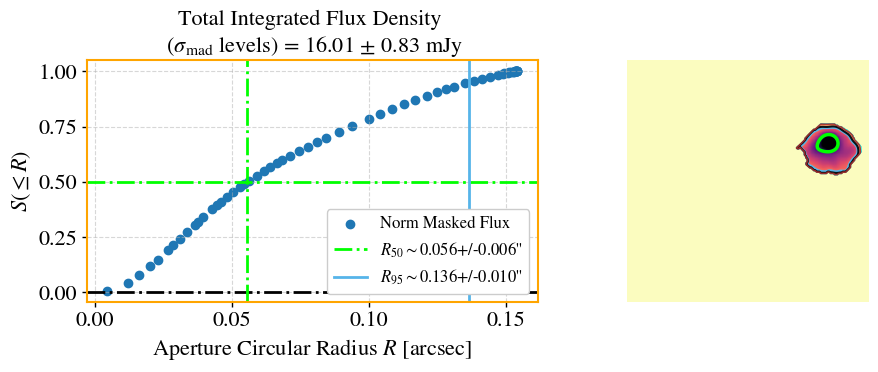

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.77s/it]


In [54]:
df_results_morpho_MFS, processing_results_source_MFS, missing_data_im_MFS = \
    mlibs.structural_morphology(imagelist = MFS_images_c, 
                                residuallist = MFS_residuals_c, 
                                indices=list(SE.indices), 
                                masks_deblended=SE.masks,
                                min_sigma=1.5,iterations=2,iterations_subregions=3,
                                ref_mask=mask,
                                verbose=1,
                                do_PLOT=True, show_figure=True,do_petro=False,
                                zd = mlibs.find_z_NED(source_name))

In [55]:
img_props = df_results_morpho_MFS.iloc[0]

In [56]:
print(f"Half-light radius R50 = {img_props['C50radii']:.2f}+/-{img_props['C50radii_err']:.2f} [px]")
print(f"Source Extent R95 = {img_props['C95radii']:.2f}+/-{img_props['C95radii_err']:.2f} [px]")
print(f"Total flux density = \
{img_props['total_flux_mask']*1000:.2f}+/-\
{img_props['flux_error_res_3']*1000:.2f} mJy")

Half-light radius R50 = 11.46+/-1.64 [px]
Source Extent R95 = 31.79+/-3.41 [px]
Total flux density = 57.66+/-2.98 mJy


In [57]:
redshift = mlibs.find_z_NED(source_name)
cell_size=mlibs.get_cell_size(input_data.filename)

pix_to_pc = mlibs.pixsize_to_pc(z=redshift,
                               cell_size=cell_size)

print(f"Source Half-light Size = \
{img_props['C50radii']:.2f}+/-{img_props['C50radii_err']:.2f} [px]")
print(f"Source Half-light Size = \
{img_props['C50radii']*cell_size*1000:.2f}+/-{img_props['C50radii_err']*cell_size*1000:.2f} [mas]")
print(f"Source Half-light Size = \
{img_props['C50radii']*pix_to_pc:.2f}+/-{img_props['C50radii_err']*pix_to_pc:.2f} [pc]")

print('++++++++++++++++++++++')

print(f"Source Total Size - using R95 (stable)")
print(f"R95 = \
{img_props['C95radii']:.2f}+/-{img_props['C95radii_err']:.2f} [px]")
print(f"R95 = \
{img_props['C95radii']*cell_size*1000:.2f}+/-{img_props['C95radii_err']*cell_size*1000:.2f}[mas]")
print(f"R95 = \
{img_props['C95radii']*pix_to_pc:.2f}+/-{img_props['C95radii_err']*pix_to_pc:.2f} [pc]")

Source Half-light Size = 11.46+/-1.64 [px]
Source Half-light Size = 91.65+/-13.11 [mas]
Source Half-light Size = 55.05+/-7.88 [pc]
++++++++++++++++++++++
Source Total Size - using R95 (stable)
R95 = 31.79+/-3.41 [px]
R95 = 254.36+/-27.31[mas]
R95 = 152.79+/-16.41 [pc]


In [58]:
print(f"Source Total Size - using R99 (not stable)")
print(f"R99 = \
{img_props['C99radii']:.2f}+/-{img_props['C99radii_err']:.2f} [px]")
print(f"R99 = \
{img_props['C99radii']*cell_size*1000:.2f}+/-{img_props['C99radii_err']*cell_size*1000:.2f}[mas]")
print(f"R99 = \
{img_props['C99radii']*pix_to_pc:.2f}+/-{img_props['C99radii_err']*pix_to_pc:.2f} [pc]")

Source Total Size - using R99 (not stable)
R99 = 37.11+/-4.27 [px]
R99 = 296.86+/-34.13[mas]
R99 = 178.32+/-20.50 [pc]


In [59]:
print(f"Convex Position Angle = \
{img_props['PA_convex']:.2f} [degrees]")
print(f"Convex Axis Ratio = \
{img_props['q_convex']:.2f}")
print(f"Major Diameter = \
{img_props['convex_major_diameter']*cell_size*1000:.2f} [mas]")
print(f"Minor Diameter = \
{img_props['convex_minor_diameter']*cell_size*1000:.2f} [mas]")

print(f"Moment Position Angle = \
{img_props['PAdeg_mom']:.2f} [deg]")
print(f"Moment axis ratio = \
{img_props['q_mom']:.2f}")



Convex Position Angle = 16.94 [degrees]
Convex Axis Ratio = 0.31
Major Diameter = 1124.16 [mas]
Minor Diameter = 416.86 [mas]
Moment Position Angle = 20.15 [deg]
Moment axis ratio = 0.21


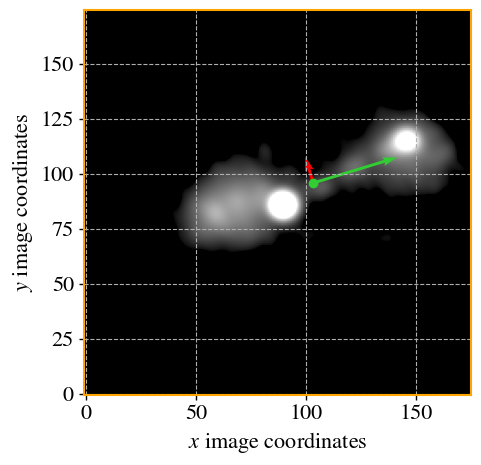

PA = 16.94417167626393
q = 0.3138108334083577
major_diameter = 1124.16 [mas]
minor_diameter = 416.86 [mas]


In [60]:
"""
For reference, the function that calculates these properties can be called as:
"""
# reload_libs()
convex_props = mlibs.convex_morpho(input_data.image_data_2D, mask, do_plot=True)
print(f"PA = {convex_props['PA_convex']}")
print(f"q = {convex_props['q_convex']}")
print(f"major_diameter = {convex_props['major_diameter']*cell_size*1000:.2f} [mas]")
print(f"minor_diameter = {convex_props['minor_diameter']*cell_size*1000:.2f} [mas]")


## Analysis of Sub-band images
We now proceed to the analysis of the sub-band images. We do as before, computing flux densities, sizes, etc for images along the frequency axis. We then will have a SED for the global emission and for individual regions, given that the source extraction was possible. 

In [63]:
imagelist_run = imagelist_c.copy()
residuallist_run = residuallist_c.copy()
frequencies = freqlist.copy()
imagelist_run

['/tmp/disk/LIRGI_Sample_done/for_spix/NGC7674/eM_C_Ka/C/im_nc6_cb_bs_0.06asec_NGC7674_eM_C_sfc_ps_highres_C_Ka_1024x1024_0.008asec_multiscale__r0.0-0000-image-pb.cutout.total_highres.fits',
 '/tmp/disk/LIRGI_Sample_done/for_spix/NGC7674/eM_C_Ka/C/im_nc6_cb_bs_0.06asec_NGC7674_eM_C_sfc_ps_highres_C_Ka_1024x1024_0.008asec_multiscale__r0.0-0001-image-pb.cutout.total_highres.fits',
 '/tmp/disk/LIRGI_Sample_done/for_spix/NGC7674/eM_C_Ka/C/im_nc6_cb_bs_0.06asec_NGC7674_eM_C_sfc_ps_highres_C_Ka_1024x1024_0.008asec_multiscale__r0.0-0002-image-pb.cutout.total_highres.fits',
 '/tmp/disk/LIRGI_Sample_done/for_spix/NGC7674/eM_C_Ka/C/im_nc6_cb_bs_0.06asec_NGC7674_eM_C_sfc_ps_highres_C_Ka_1024x1024_0.008asec_multiscale__r0.0-0003-image-pb.cutout.total_highres.fits',
 '/tmp/disk/LIRGI_Sample_done/for_spix/NGC7674/eM_C_Ka/C/im_nc6_cb_bs_0.06asec_NGC7674_eM_C_sfc_ps_highres_C_Ka_1024x1024_0.008asec_multiscale__r0.0-0004-image-pb.cutout.total_highres.fits',
 '/tmp/disk/LIRGI_Sample_done/for_spix/NGC767

In [64]:
df_results_morpho, processing_results_source, missing_data_im = \
    mlibs.structural_morphology(imagelist = imagelist_run, 
                                residuallist = residuallist_run, 
                                indices=list(SE.indices), 
                                masks_deblended=SE.masks,
                                min_sigma=1.5,iterations=2,iterations_subregions=3,
                                ref_mask=mask,do_petro=False,
                                zd = mlibs.find_z_NED(source_name))
# df_results_morpho.to_csv(f"./high_res_results/{source_name}_{special_name}_for_SED_highres_0.04asec_sub_morpho_subband_images.csv",header=True,index=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:58<00:00,  9.77s/it]


In [67]:
# df_source = df[df['comp_ID'].isna()]
df_source = df_results_morpho[df_results_morpho['comp_ID']=='0']
freqs = df_source['freq']/1e9
data_flux = df_source['total_flux_mask']*1000
data_flux_err = df_source['flux_error_res_3']*1000

[]

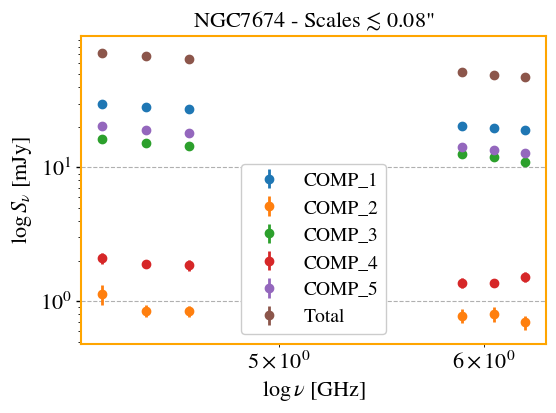

In [68]:
total_flux_inc = 0.0
if len(SE.indices) == 1:
    filtered_df = df_results_morpho[df_results_morpho['comp_ID'] == str(0)]
    total_flux_inc = total_flux_inc + filtered_df['total_flux_mask'].iloc[0]*1000
else:
    # mlibs.plt.figure(figsize=(6,3))
    for j in range(1,len(SE.indices)+1):
        filtered_df = df_results_morpho[df_results_morpho['comp_ID'] == str(j)]
    #     filtered_df = df_results[df_results['comp_ID'] == str(SE.indices[j])]
        total_flux_inc = total_flux_inc + filtered_df['total_flux_mask'].iloc[0]*1000
        mlibs.plt.errorbar((filtered_df['freq']/1e9),(filtered_df['total_flux_mask']*1000),
                           yerr=abs(filtered_df['flux_error_res_3']*1000),fmt='o',label=f"COMP_{j}")
mlibs.plt.errorbar((freqs),(data_flux),yerr=data_flux_err,fmt='o',label=f"Total")
# mlibs.plt.legend()
mlibs.plt.xlabel(r'$\log \nu$ [GHz]')
mlibs.plt.ylabel(r'$\log S_{\nu}$ [mJy]')
mlibs.plt.title(f'{source_name} - Scales $\lesssim$ {10*cell_size:.2f}"')
# mlibs.plt.axhline(1, color='black')
mlibs.plt.legend()
mlibs.plt.semilogy()
mlibs.plt.semilogx()


### In-band integrated spectral index fit.
We can do that for the total emission, but also, for each individual region.

In [93]:
comp_id = 0 # global total emission
fluxes = df_results_morpho[df_results_morpho['comp_ID'] == str(comp_id)]['total_flux_mask'].values*1000
fluxes_err = df_results_morpho[df_results_morpho['comp_ID'] == str(comp_id)]['flux_error_res_3'].values*1000

  ++==>> Number of walkers: 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 328.23it/s]


{'A1': {'best': 29.108405932603716, 'lower_bound': 26.563884842109633, 'upper_bound': 31.843368855987702, 'lower': 2.544521090494083, 'upper': 2.7349629233839856}, 'alpha': {'best': -1.0513187328022222, 'lower_bound': -1.187097615396243, 'upper_bound': -0.9171438268455571, 'lower': 0.1357788825940207, 'upper': 0.13417490595666515}}


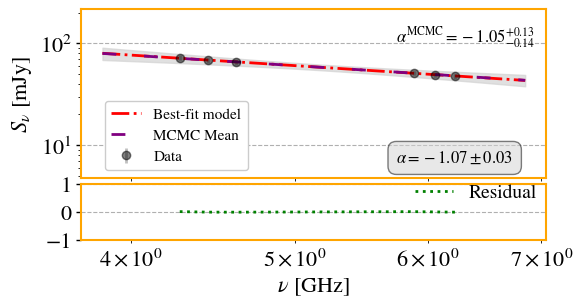

(100000, 2)


<Figure size 600x400 with 0 Axes>

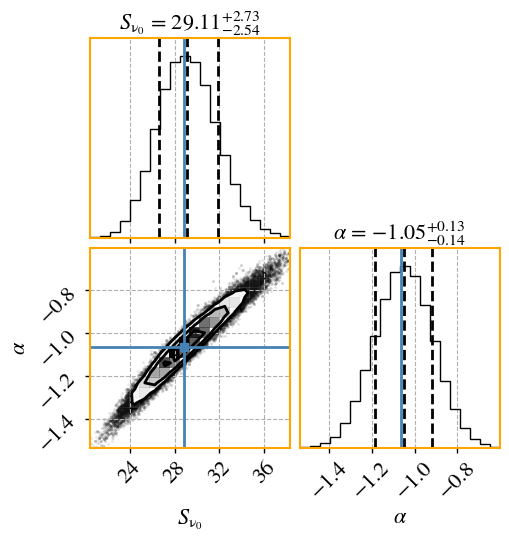

++==>> Parameter Results (MCMC sampling).
++==>> Parameter Results (from least-squares fit).
[[Variables]]
    A1:     28.8301944 +/- 0.62926416 (2.18%) (init = 28.83019)
    alpha: -1.06577130 +/- 0.03153025 (2.96%) (init = -1.065771)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, alpha) = 0.975


In [96]:
# reload_libs()
mini_1,result_1, param_dict = \
    mlibs.do_fit_spec_RC_linear(freqs=df_results_morpho[df_results_morpho['comp_ID'] == str(comp_id)]['freq'].values, #in Hz
                         fluxes=fluxes,
                         fluxes_err=fluxes_err,
                         nu0=10.0, #in GHz
                         plot_errors_shade=True,
                         do_mcmc_fit=True,
                         # title_text = r'Extended Emission'
                        )

In [98]:
comp_id = 2 # AGN/core
fluxes = df_results_morpho[df_results_morpho['comp_ID'] == str(comp_id)]['total_flux_mask'].values*1000
fluxes_err = df_results_morpho[df_results_morpho['comp_ID'] == str(comp_id)]['flux_error_res_3'].values*1000

  ++==>> Number of walkers: 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 328.40it/s]


{'A1': {'best': 0.5857717040936785, 'lower_bound': 0.4710620407336237, 'upper_bound': 0.7245321985569377, 'lower': 0.11470966336005484, 'upper': 0.13876049446325922}, 'alpha': {'best': -0.49612345220397924, 'lower_bound': -0.8177372643074307, 'upper_bound': -0.17399586888617458, 'lower': 0.3216138121034514, 'upper': 0.32212758331780467}}


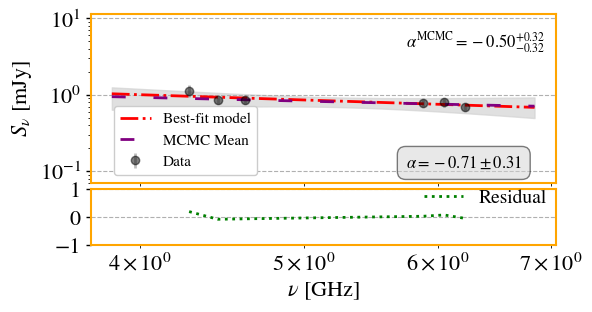

(100000, 2)


<Figure size 600x400 with 0 Axes>

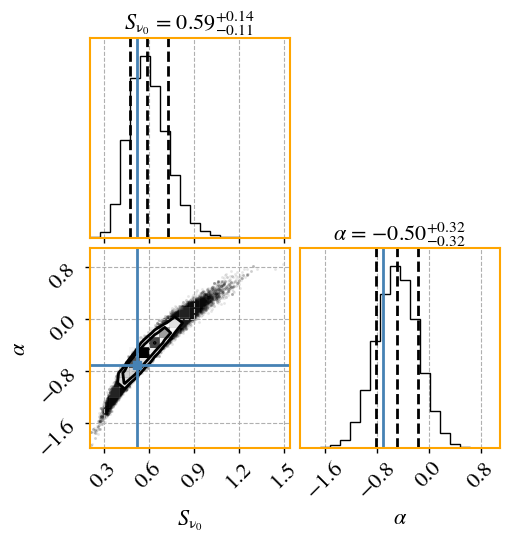

++==>> Parameter Results (MCMC sampling).
++==>> Parameter Results (from least-squares fit).
[[Variables]]
    A1:     0.52170864 +/- 0.11095708 (21.27%) (init = 0.5217086)
    alpha: -0.71103609 +/- 0.30606799 (43.05%) (init = -0.7110361)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, alpha) = 0.976


In [99]:
# reload_libs()
mini_1,result_1, param_dict = \
    mlibs.do_fit_spec_RC_linear(freqs=df_results_morpho[df_results_morpho['comp_ID'] == str(comp_id)]['freq'].values, #in Hz
                         fluxes=fluxes,
                         fluxes_err=fluxes_err,
                         nu0=10.0, #in GHz
                         plot_errors_shade=True,
                         do_mcmc_fit=True,
                         # title_text = r'Extended Emission'
                        )

## Spectral Index Maps
With the sub-band images, we also can compute spectral index maps. 

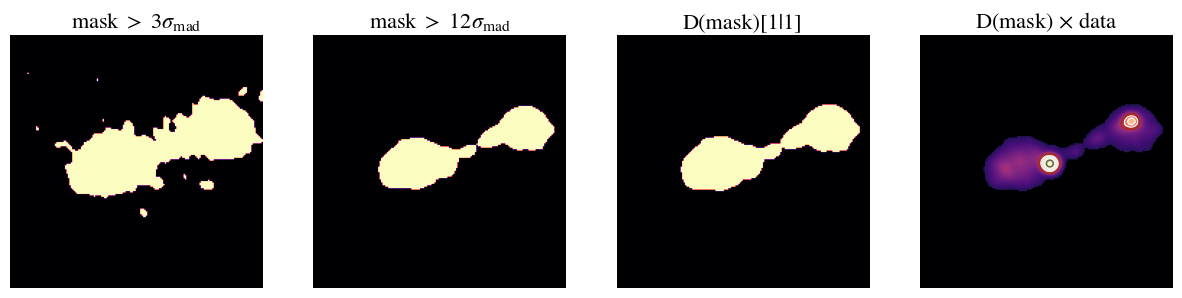

<Figure size 500x500 with 0 Axes>

In [75]:
_,mask_alpha = mlibs.mask_dilation(input_data.filename,
                                   rms=input_data.rms_res,
                                   iterations=1,sigma=12,
                                   # dilation_size=None, # or any int
                                   PLOT=True,show_figure=True
                                 )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2979/2979 [00:04<00:00, 728.20it/s]


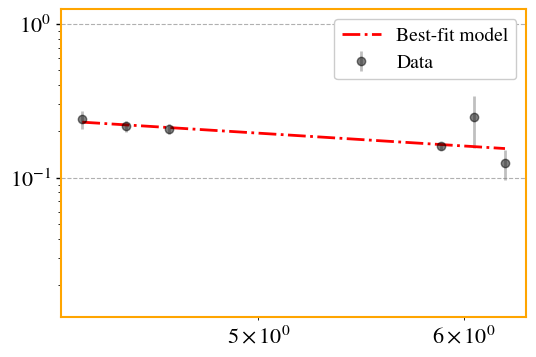

[[Variables]]
    alpha: -1.05326031 +/- 0.48132969 (45.70%) (init = -1.05326)
    b:      0.09366049 +/- 0.03268953 (34.90%) (init = 0.09366049)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, b) = 0.981


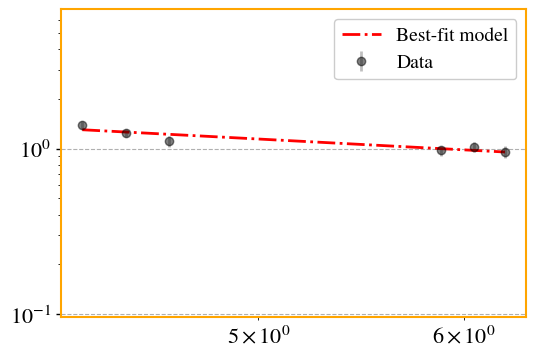

[[Variables]]
    alpha: -0.82440314 +/- 0.17269386 (20.95%) (init = -0.8244031)
    b:      0.64529807 +/- 0.07940288 (12.30%) (init = 0.6452981)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, b) = 0.977


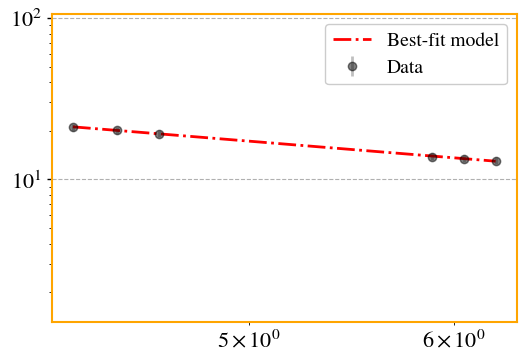

[[Variables]]
    alpha: -1.30493225 +/- 0.01808458 (1.39%) (init = -1.304932)
    b:      6.98490898 +/- 0.09062794 (1.30%) (init = 6.984909)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, b) = 0.977


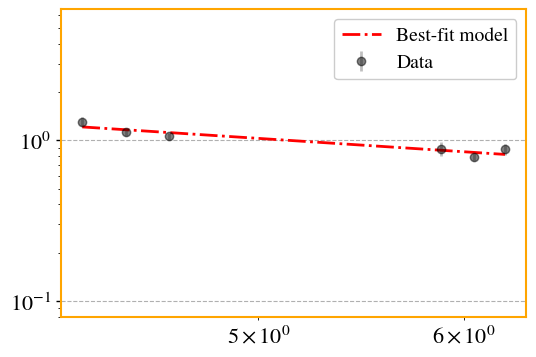

[[Variables]]
    alpha: -1.04996254 +/- 0.19445573 (18.52%) (init = -1.049963)
    b:      0.49763730 +/- 0.06964954 (14.00%) (init = 0.4976373)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, b) = 0.978


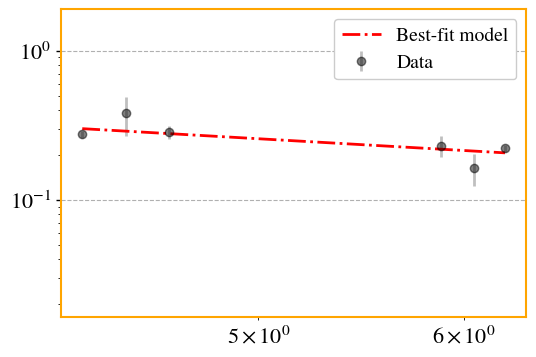

[[Variables]]
    alpha: -0.99546559 +/- 0.42612288 (42.81%) (init = -0.9954656)
    b:      0.12862632 +/- 0.03934563 (30.59%) (init = 0.1286263)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, b) = 0.975


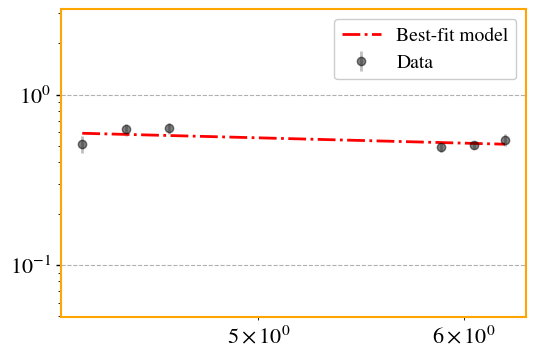

[[Variables]]
    alpha: -0.39365560 +/- 0.26657910 (67.72%) (init = -0.3936556)
    b:      0.42420246 +/- 0.07625291 (17.98%) (init = 0.4242025)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, b) = 0.973


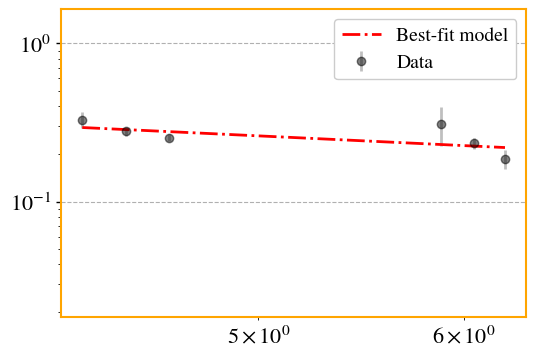

[[Variables]]
    alpha: -0.77701178 +/- 0.41517853 (53.43%) (init = -0.7770118)
    b:      0.15181585 +/- 0.04546086 (29.94%) (init = 0.1518159)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, b) = 0.979


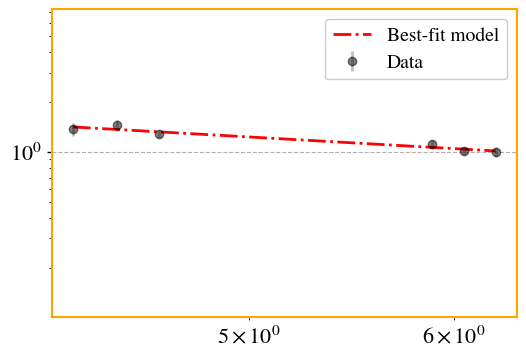

[[Variables]]
    alpha: -0.88855705 +/- 0.12604830 (14.19%) (init = -0.888557)
    b:      0.66443361 +/- 0.05820296 (8.76%) (init = 0.6644336)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, b) = 0.975


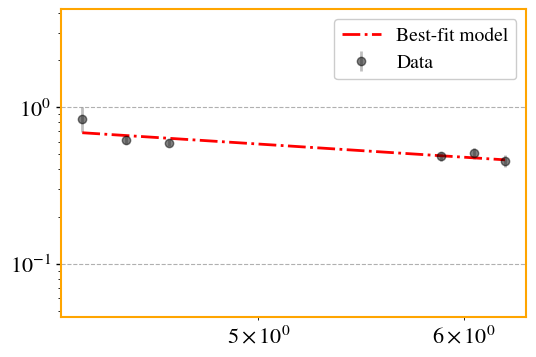

[[Variables]]
    alpha: -1.06298000 +/- 0.31378265 (29.52%) (init = -1.06298)
    b:      0.27850817 +/- 0.06149260 (22.08%) (init = 0.2785082)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, b) = 0.978


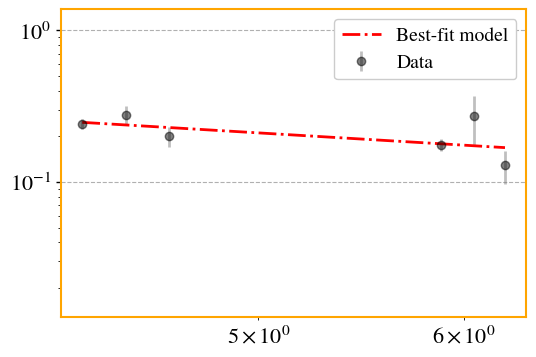

[[Variables]]
    alpha: -1.02156525 +/- 0.59672979 (58.41%) (init = -1.021565)
    b:      0.10372788 +/- 0.04537718 (43.75%) (init = 0.1037279)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, b) = 0.980


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 67.62it/s]


In [76]:
alphaimage, alphaimage_error,conv_cube,masked_cube_res,masked_cube = \
    mlibs.specidx_map(imagelist=imagelist_run,
                      residuallist=residuallist_run,
                      freqs=freqlist,
                      mask=mask_alpha,
                      dilation_size=None,
                      verbose=1,
                      n_jobs = 16,
                      # do_average_cube=True,bin_size=int(2),
                      # nu0=np.nanmean(freqlist)/1e9,
                      # sigma_global_mask=6
                     )

<Figure size 1000x1000 with 0 Axes>

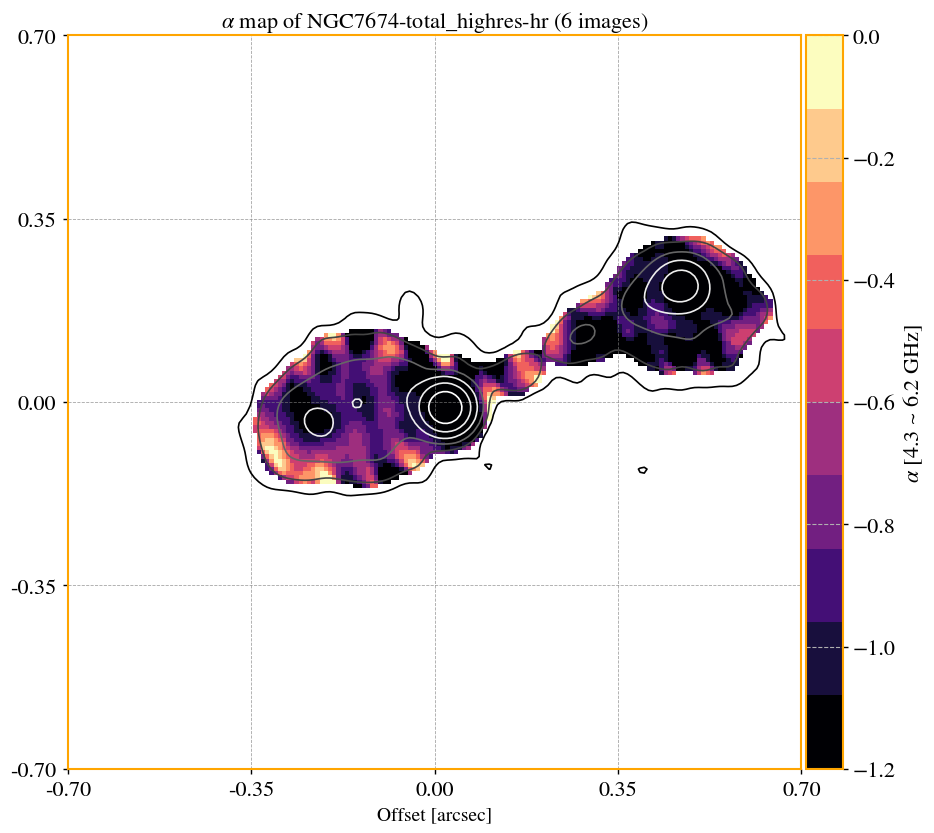

In [79]:
projection='offset'
box_size=(25,25)
crop=False


mlibs.plot_alpha_map(alphaimage=alphaimage,
                     radio_map=MFS_images_c[idx],
                     figsize=(10,10),
                     plot_title=rf'$\alpha$ map of {source_name}-{special_name}-hr',cmap='magma',
                     rms=mlibs.mad_std(mlibs.load_fits_data(MFS_residuals_c[idx])),
                     # vmax=np.nanmedian(alphaimage) +3*mlibs.mad_std(alphaimage,ignore_nan=True),
                     # vmin = -1.2,
                     # vmin=np.nanmedian(alphaimage) -3*mlibs.mad_std(alphaimage,ignore_nan=True),
                     vmax=0.0,vmin=-1.2,
                     projection=projection,
                     box_size=box_size,crop=crop,
                     frequencies=frequencies,
                     save_name=f'alpha_map_{source_name}_{special_name}.pdf'
                    )

/tmp/ipykernel_16244/2639783703.py:5: DeprecationWarning: 'ctn' is deprecated and will be removed in a future version. Use 'load_fits_data' instead.
  rms=mlibs.mad_std(mlibs.ctn(MFS_residuals_c[idx])),


<Figure size 1000x1000 with 0 Axes>

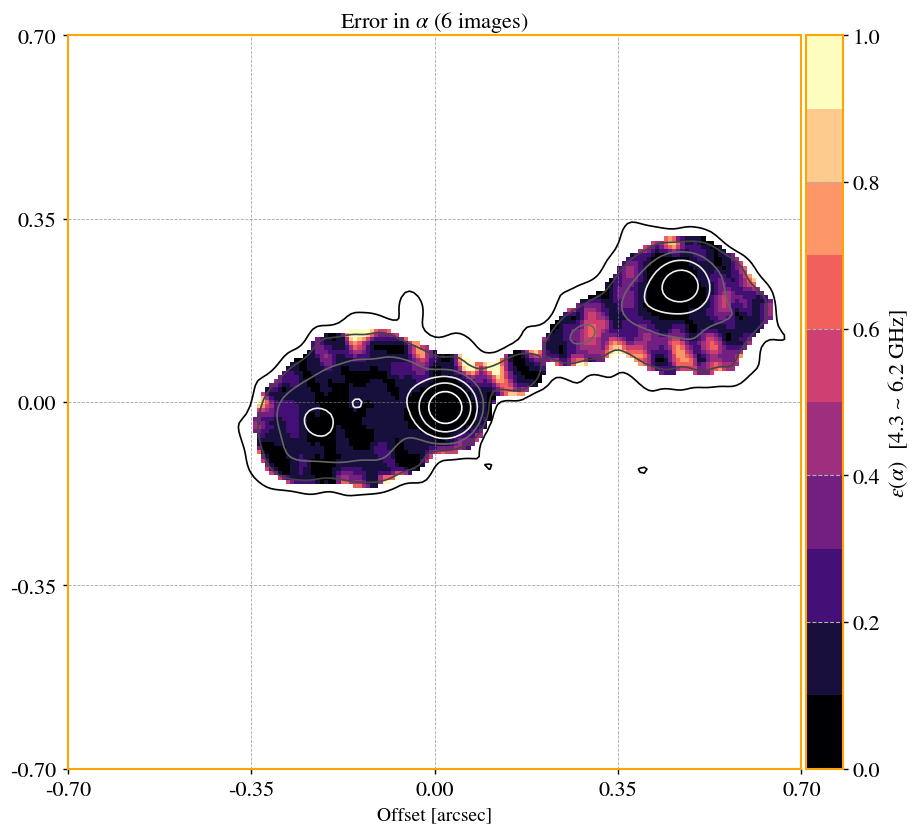

In [81]:
mlibs.plot_alpha_map(alphaimage=abs(alphaimage_error*alphaimage),
                     figsize=(10, 10),
                     radio_map=MFS_images_c[idx],
                     plot_title=r'Error in $\alpha$',cmap='magma',
                     rms=mlibs.mad_std(mlibs.ctn(MFS_residuals_c[idx])),
                     vmin=0,vmax=1,
                     projection=projection,
                     box_size=box_size,crop=crop,
                     label_colorbar=r'$\varepsilon(\alpha)$  ',
                     frequencies=frequencies,
                     save_name=f'alpha_error_map_{source_name}_{special_name}.pdf'
                    )

(-1.5, -0.1)

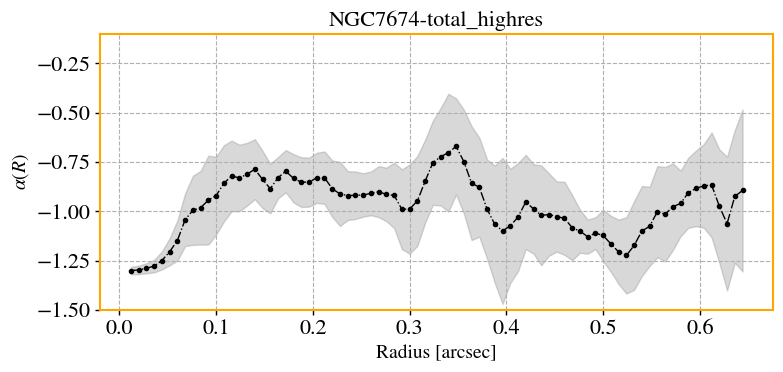

In [90]:
centre = mlibs.nd.maximum_position(mlibs.load_fits_data(MFS_images_c[idx]))[::-1]
cell_size = mlibs.get_cell_size(MFS_images_c[idx])

bin_centers, profile, error_rms, error_stdl,points_per_bin = \
    mlibs.plot_azimuthal_profile(image=alphaimage,
                                 rms_image = abs(alphaimage*alphaimage_error),
                                 center=centre,log_scale=False,
                                 cell_size=mlibs.get_cell_size(MFS_images_c[idx]),
                                 ylabel=r'$\alpha(R)$',
                                 xlabel=r'Radius [arcsec]',
                                 figsize=(8,4),
                                 sigma=1.0,
                                 which_error='rms',which_statistics='median',
                                 weight_by_points=True,
                                 r_max = 4*mlibs.area_to_radii(np.sum(mask_alpha)),
                                 title=rf'{source_name}-{special_name}'
                                )
# mlibs.plt.ylim(-1.2,np.nanpercentile(alphaimage,99.9))
mlibs.plt.ylim(-1.5,-0.1)
# mlibs.plt.xlim(0,)